## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Set plots style
plt.style.use('tableau-colorblind10')

## Load Topics Data

In [3]:
topics = pd.read_csv('data/topics_by_minute.csv')
topics = topics[['date', 'channel', 'minute', 'text', 'words_topic']]

# Filter out the 'tve' channel
topics = topics[topics['channel'] != 'tve']
topics.shape

(50124, 5)

In [4]:
# Assuming your dataframe is named df and the date column is named 'date_column'
topics['date'] = pd.to_datetime(topics['date'])

# Filter out observations for May 2024
topics = topics[~((topics['date'].dt.month == 5) & (topics['date'].dt.year == 2024))]
topics.shape

(48940, 5)

In [5]:
# Create the 'ukraine' column
topics['ukraine'] = topics['words_topic'].apply(lambda x: 1 if 'ucrania' in x else 0)

# Extract the month and year from the date column
topics['year_month'] = topics['date'].dt.to_period('M')

In [6]:
topics.date.min(), topics.date.max()

(Timestamp('2022-12-02 00:00:00'), Timestamp('2024-04-30 00:00:00'))

## Share of Time Speaking about the Russia-Ukraine War

In [8]:
# Group by year_month and channel, and count total records and records with 'ukraine' = 1
observations_by_month = topics.groupby(['channel', 'year_month']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()

# Calculate the share of records mentioning 'ukraine'
observations_by_month['share_with_ukraine'] = observations_by_month['num_with_ukraine'] / observations_by_month['total_records']

# Convert 'year_month' to a datetime format
observations_by_month['year_month'] = observations_by_month['year_month'].dt.to_timestamp()

observations_by_month.head()

,channel,year_month,total_records,num_with_ukraine,share_with_ukraine
0,a3,2022-12-01,886,81,0.091422
1,a3,2023-01-01,1039,153,0.147257
2,a3,2023-02-01,935,183,0.195722
3,a3,2023-03-01,1027,115,0.111977
4,a3,2023-04-01,966,88,0.091097


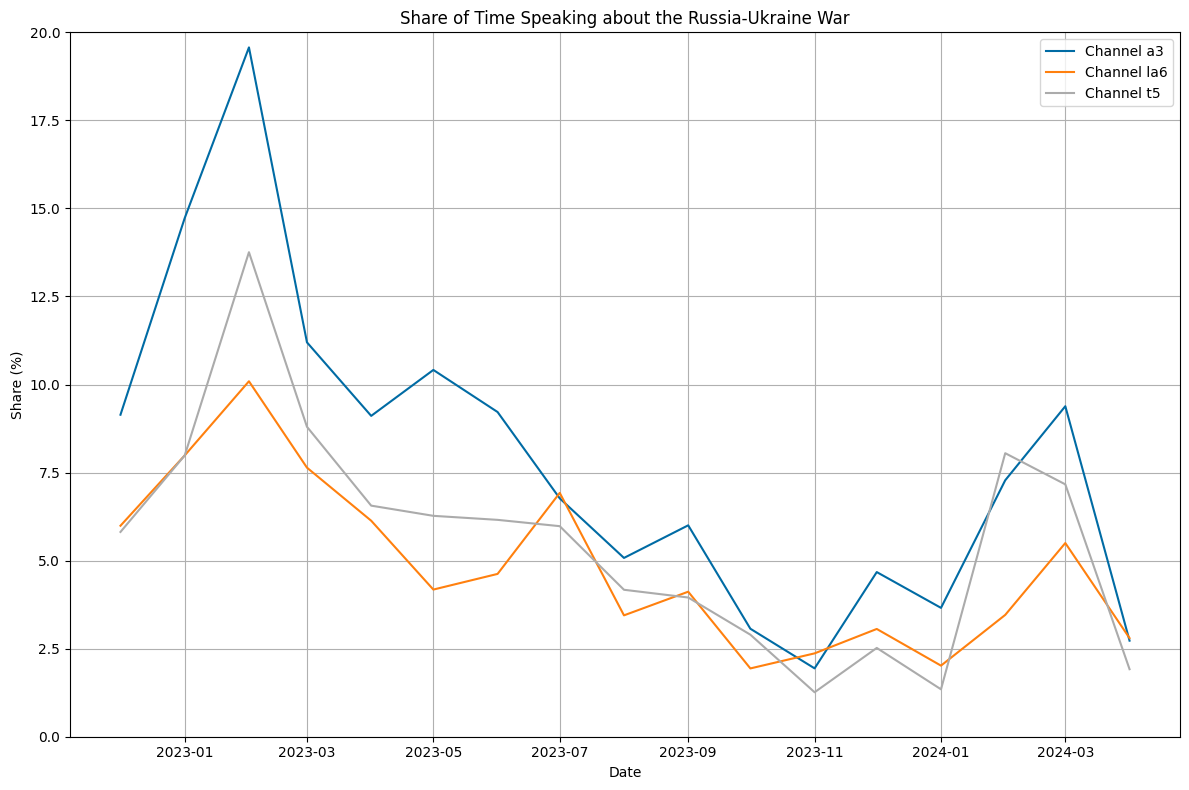

In [9]:
# Plotting
plt.figure(figsize=(12, 8))

channels = observations_by_month['channel'].unique()

for channel in channels:
    channel_data = observations_by_month[observations_by_month['channel'] == channel]
    plt.plot(channel_data['year_month'], channel_data['share_with_ukraine'] * 100, label=f'Channel {channel}')

plt.title('Share of Time Speaking about the Russia-Ukraine War')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

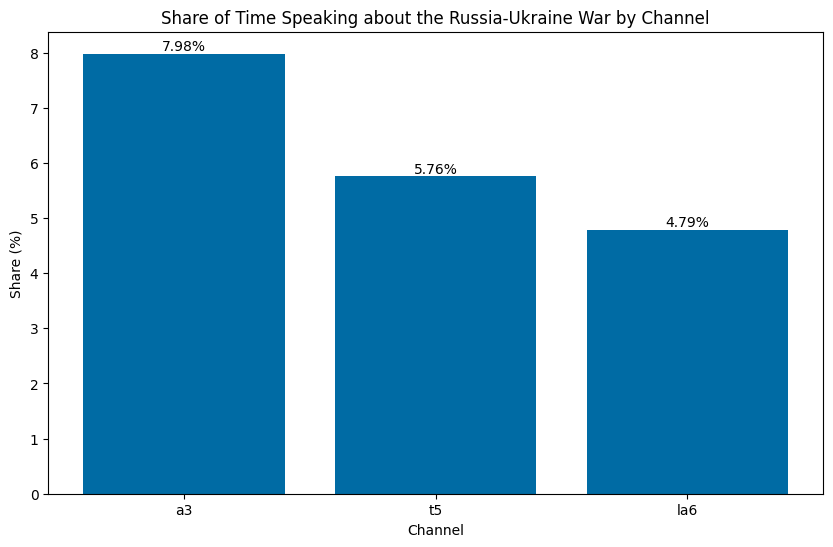

In [10]:
# Group by 'channel' and calculate the total 'total_records' and 'num_with_ukraine'
channel_summary = observations_by_month.groupby('channel').agg({
    'total_records': 'sum',
    'num_with_ukraine': 'sum'
}).reset_index()

# Calculate 'share_with_ukraine'
channel_summary['share_with_ukraine'] = channel_summary['num_with_ukraine'] / channel_summary['total_records']

# Sort the DataFrame by 'share_with_ukraine' in descending order
channel_summary = channel_summary.sort_values(by='share_with_ukraine', ascending=False)

# Convert 'share_with_ukraine' to percentages
channel_summary['share_with_ukraine'] = channel_summary['share_with_ukraine'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_summary['channel'], channel_summary['share_with_ukraine'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of Time Speaking about the Russia-Ukraine War by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

## Restructure Topics Data for Future Use

In [12]:
# Convert 'year_month' to datetime format
observations_by_month['year_month'] = pd.to_datetime(observations_by_month['year_month'])

# Group by 'year_month' and aggregate
df_restructured = observations_by_month.groupby('year_month').agg(
    total_records=('total_records', 'sum'),
    num_with_ukraine=('num_with_ukraine', 'sum')
).reset_index()

# Calculate 'share_with_ukraine'
df_restructured['share_with_ukraine'] = df_restructured['num_with_ukraine'] / df_restructured['total_records']

# Sort by 'year_month'
df_restructured = df_restructured.sort_values(by='year_month')

# Make sure observations_by_month is also sorted
observations_by_month = observations_by_month.sort_values(by=['channel', 'year_month'])

# Add shares for each channel as a separate column
df_restructured['a3_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'a3'].reset_index()['share_with_ukraine']
df_restructured['la6_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'la6'].reset_index()['share_with_ukraine']
df_restructured['t5_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 't5'].reset_index()['share_with_ukraine']
df_restructured.head()

,year_month,total_records,num_with_ukraine,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,2962,204,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,3155,322,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,2989,422,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,3224,293,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,2963,214,0.072224,0.091097,0.061329,0.065614


## Explore Missing Data

### Number of Missing Transcrips (Number of Missing Dates in the Topics File)

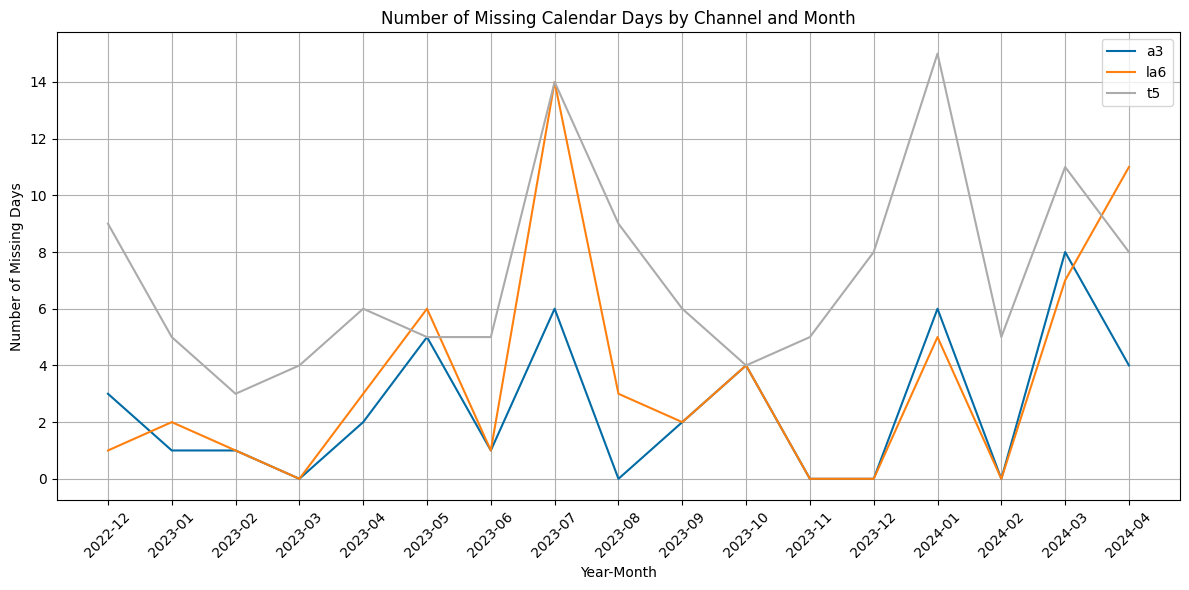

In [13]:
import calendar

# Group by 'channel' and 'year_month' and count unique days
grouped = topics.groupby(['channel', 'year_month'])['date'].nunique().reset_index()
grouped = grouped.rename(columns={'date': 'unique_days'})

# Calculate the number of days in each month
grouped['days_in_month'] = grouped['year_month'].apply(lambda x: calendar.monthrange(x.year, x.month)[1])

# Calculate missing days
grouped['missing_days'] = grouped['days_in_month'] - grouped['unique_days']

# Plot the missing days
plt.figure(figsize=(12, 6))
for channel in grouped['channel'].unique():
    channel_data = grouped[grouped['channel'] == channel]
    plt.plot(channel_data['year_month'].astype(str), channel_data['missing_days'], label=channel)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Missing Days')
plt.title('Number of Missing Calendar Days by Channel and Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

### Number of Missing Videos

(out of those present in the topics file, the Russia-Ukraine War topic only)

! DO NOT RUN THIS SECTION

In [42]:
folder = 'data/frames'
subfolders = ['atres', 'la6', 'telecinco']

# Dictionary to store the list of files for each subfolder
files_in_subfolders = {}

# Iterate through each subfolder and get the list of files
for subfolder in subfolders:
    subfolder_path = os.path.join(folder, subfolder)
    # List all files in the subfolder
    files = os.listdir(subfolder_path)
    files_in_subfolders[subfolder] = files

atres_files = files_in_subfolders['atres']
la6_files = files_in_subfolders['la6']
telecinco_files = files_in_subfolders['telecinco']

print(len(atres_files))
print(len(la6_files))
print(len(telecinco_files))

48039
57931
46237


In [44]:
# Function to filter files that end with .jpg
def filter_jpg_files(file_list):
    if file_list is not None:
        return [file for file in file_list if file.endswith('.jpg')]
    return []

# Filter .jpg files in each subfolder
atres_files_jpg = filter_jpg_files(files_in_subfolders['atres'])
la6_files_jpg = filter_jpg_files(files_in_subfolders['la6'])
telecinco_files_jpg = filter_jpg_files(files_in_subfolders['telecinco'])

print(len(atres_files_jpg))
print(len(la6_files_jpg))
print(len(telecinco_files_jpg))

48038
57928
46236


In [49]:
atres_dates = list(set([name.split('_')[3] for name in atres_files_jpg]))
la6_dates = list(set([name.split('_')[3] for name in la6_files_jpg]))
t5_dates = list(set([name.split('_')[3] for name in telecinco_files_jpg]))

# Num of unique dates in the folder
len(atres_dates), len(la6_dates), len(t5_dates)

(304, 310, 294)

In [48]:
# Filter the DataFrame
topics_ua = topics[topics['words_topic'].apply(lambda x: 'ucrania' in x)]
print(topics_ua.shape)

a3_df = topics_ua[topics_ua.channel == 'a3']
la6_df = topics_ua[topics_ua.channel == 'la6']
t5_df = topics_ua[topics_ua.channel == 't5']

a3_dates_topics = a3_df.date.unique()
la6_dates_topics = la6_df.date.unique()
t5_dates_topics = t5_df.date.unique()

# Num of unique dates in the topics file
len(a3_dates_topics), len(la6_dates_topics), len(t5_dates_topics)

(2964, 7)


(393, 318, 281)

In [50]:
# Convert string dates to datetime
atres_dates_dt = pd.to_datetime(atres_dates)
la6_dates_dt = pd.to_datetime(la6_dates)
t5_dates_dt = pd.to_datetime(t5_dates)

# Find dates in a3_dates_topics not in atres_dates_dt
a3_diff = [date for date in a3_dates_topics if date not in atres_dates_dt]

# Find dates in la6_dates_topics not in la6_dates_dt
la6_diff = [date for date in la6_dates_topics if date not in la6_dates_dt]

# Find dates in t5_dates_topics not in t5_dates_dt
t5_diff = [date for date in t5_dates_topics if date not in t5_dates_dt]

len(a3_diff), len(la6_diff), len(t5_diff)

(104, 8, 0)

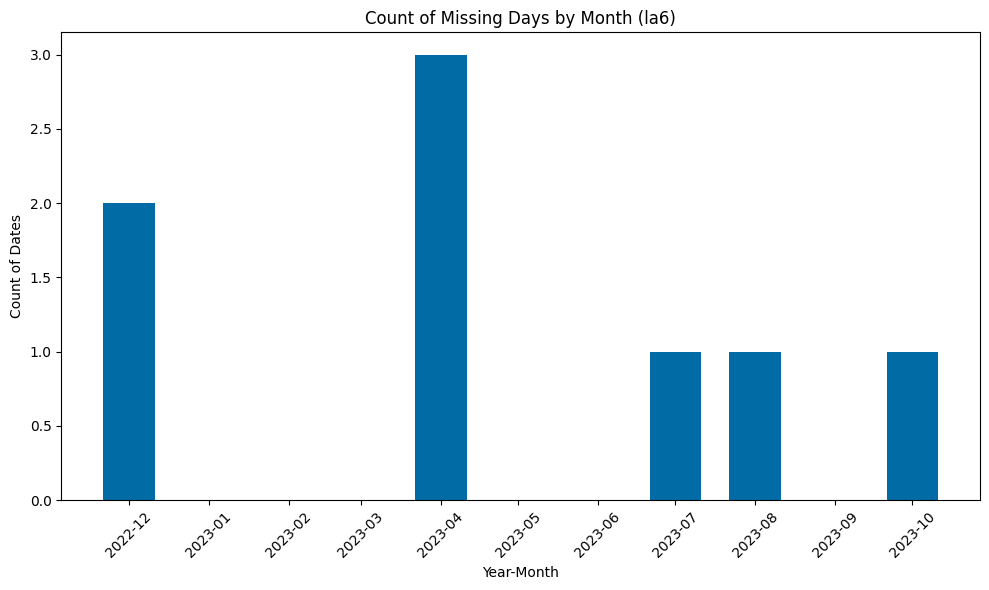

In [72]:
# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
la6_missing_by_month = la6_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
la6_missing_by_month = la6_missing_by_month.reset_index()
la6_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
la6_missing_by_month['year_month'] = la6_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(la6_missing_by_month['year_month'], la6_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (la6)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

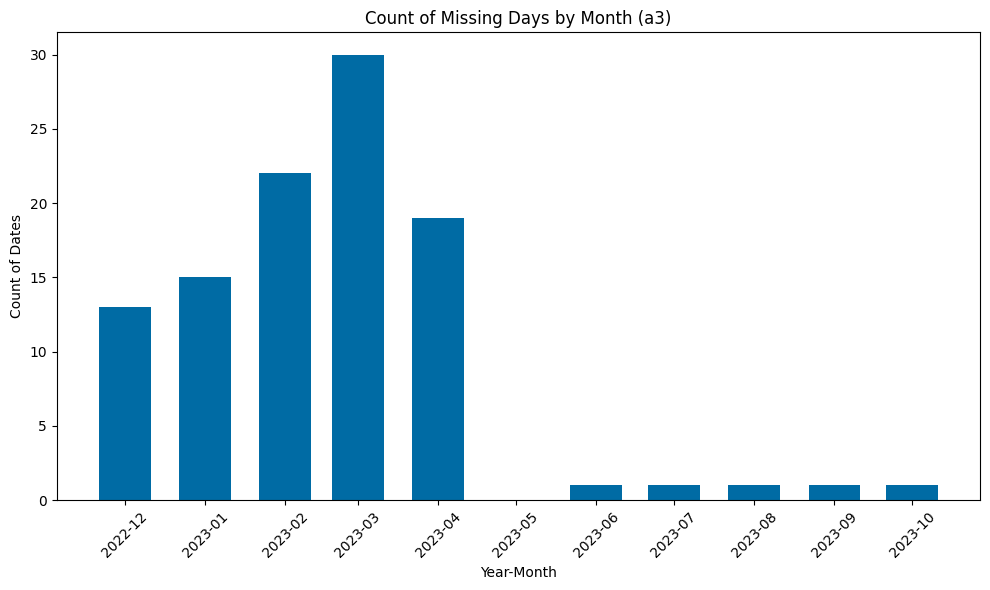

In [73]:
# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
a3_missing_by_month = a3_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
a3_missing_by_month = a3_missing_by_month.reset_index()
a3_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
a3_missing_by_month['year_month'] = a3_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(a3_missing_by_month['year_month'], a3_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (a3)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Load Additional Data

### Massive Missile Attacks on Ukraine

In [14]:
# Load data
df_missiles_daily = pd.read_csv('additional_data/missile_attacks/missile_attacks_daily.csv')
df_missiles_description = pd.read_csv('additional_data/missile_attacks/missiles_and_uav.csv')
df_missiles = df_missiles_daily.merge(df_missiles_description, how='left', on=['model'])
print(df_missiles.shape)
display(df_missiles)

(1167, 21)


,time_start,time_end,model,launch_place,target,destroyed_details,carrier,launched,destroyed,source,...,national_origin,type,launch_platform,name,name_NATO,guidance_system,features,unit_cost,produced,manufacturer
0,2024-06-08,2024-06-08 08:00,X-59,Kursk oblast,east,NaN,NaN,1.0,1,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN
1,2024-06-08,2024-06-08 08:00,Supercam,NaN,east,NaN,NaN,2.0,2,pvkshid/posts/pfbid02x9v3uZxSB3TgdedK5kF7DyNPN...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmanned Systems Group
2,2024-06-08,2024-06-08 08:00,Shahed-136/131,"Chauda, Crimea and Kursk oblast",Ukraine,"{'Poltava oblast': 1, 'Kharkiv oblast': NaN, '...",NaN,13.0,9,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
3,2024-06-08,2024-06-08,Lancet,NaN,Kherson oblast,NaN,NaN,4.0,4,PvKPivden/posts/pfbid02GLn4kq7vQfjLQD4vaKycwQD...,...,russia,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZALA Aero Group
4,2024-06-07,2024-06-07 08:00,X-101/X-555,Saratov oblast,west,NaN,Tu-95MS,5.0,5,kpszsu/posts/pfbid0zAYzn1GoGTtWFRi283Z8pnCJKZJ...,...,russia,air-launched,"Tu-95MS, Tu-160, Su-34",Kh-101/Kh-555,Kent-C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2022-10-01 12:00,2022-10-01 12:00,Orlan-10,NaN,Ukraine,NaN,NaN,1.0,1,watch/?v=375517448001233,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1163,2022-09-30,2022-09-30,Orlan-10,NaN,Ukraine,NaN,NaN,3.0,3,kpszsu/posts/pfbid0nELeXY4BpHrezv54Lk3gWPZJmcC...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1164,2022-09-29 23:00,2022-09-29 23:59,Shahed-136/131,NaN,Odesa oblast and Mykolaiv oblast,NaN,NaN,7.0,5,kpszsu/posts/pfbid021aK2TqryAuB8gGrDYMTv3R8Xiu...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
1165,2022-09-28,2022-09-28,X-59,NaN,Dnipropetrovsk oblast and Zaporizhzhia oblast,NaN,Su-35,5.0,4,kpszsu/posts/pfbid02sjn5m7kosAfsm5bSUzpPwbLuH3...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN


In [15]:
# Convert 'time_start' to datetime format using the mixed format
df_missiles['time_start'] = pd.to_datetime(df_missiles['time_start'], format='mixed')

# Extract month and year
df_missiles['year_month'] = df_missiles['time_start'].dt.to_period('M')

# Group by month and year and sum 'launched'
df_aggregated = df_missiles.groupby('year_month')['launched'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
df_aggregated['year_month'] = df_aggregated['year_month'].dt.to_timestamp()

# Rename columns for clarity
# df_aggregated.columns = ['Month', 'Total_Launched']

# Filter the DataFrame to include only months from 2022-12 to 2024-04
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
df_aggregated = df_aggregated[(df_aggregated['year_month'] >= start_date) & (df_aggregated['year_month'] <= end_date)]

In [16]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, df_restructured[['year_month', 
                                                         'share_with_ukraine',
                                                        'a3_share_with_ukraine',
                                                        'la6_share_with_ukraine',
                                                        't5_share_with_ukraine']], on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614


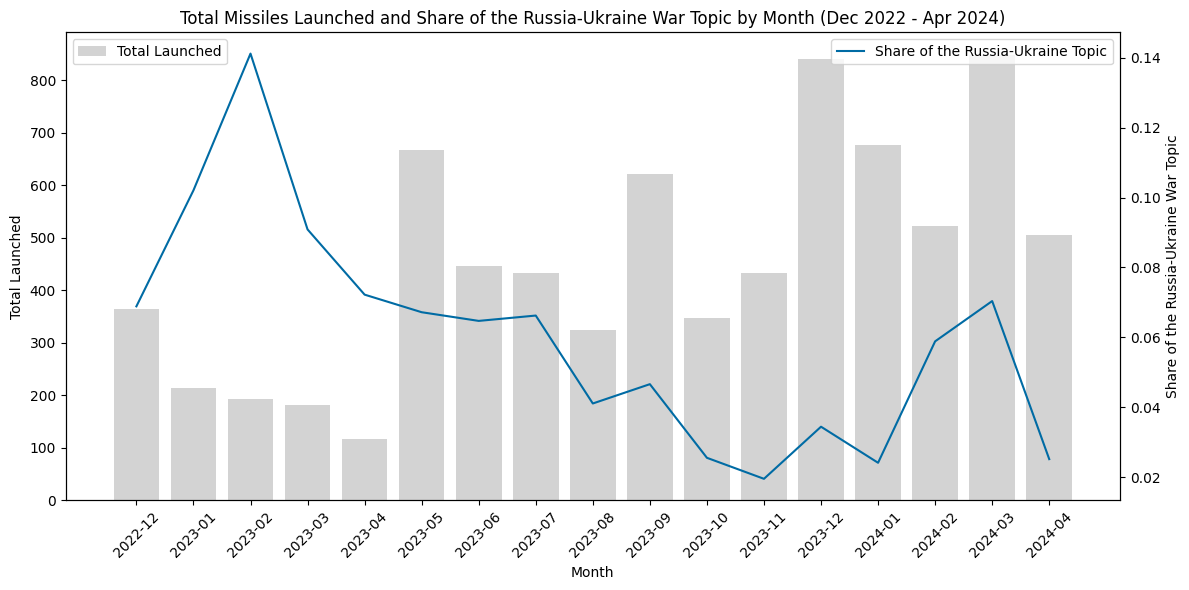

In [17]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['launched'], color='lightgrey', label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'], label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

### Number of Fatalities

In [18]:
fatalities = pd.read_csv('additional_data/number_of_fatalities/2022-12-01-2024-05-13-Europe-Ukraine.csv')
fatalities.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,UKR158104,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Zmiyinyy Island,45.2549,30.2037,1,Institute for the Study of War,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715125698
1,UKR158083,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Baranivka,51.9219,34.1846,2,Ministry of Defence of Ukraine; Suspilne Media,Other-National,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
2,UKR158084,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Bohoiavlenka,47.8601,37.2135,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
3,UKR158085,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Borova,49.3777,37.6214,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
4,UKR158086,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Chasiv Yar,48.5869,37.8324,1,Novoye Vremya Ukraine; Suspilne Media,National,"On 3 May 2024, Russian Forces launched FPV-dro...",1,NaN,1715131178


In [19]:
# Convert 'event_date' to datetime format (adjusting format to handle full month names)
fatalities['event_date'] = pd.to_datetime(fatalities['event_date'], format="%d %B %Y")

# Filter to include only months from December 2022 to April 2024
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
fatalities_filtered = fatalities[(fatalities['event_date'] >= start_date) & (fatalities['event_date'] <= end_date)]

# Group by month and sum the fatalities
fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')
fatalities_by_month = fatalities_filtered.groupby('year_month')['fatalities'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
fatalities_by_month['year_month'] = fatalities_by_month['year_month'].dt.to_timestamp()

C:\Users\gatla\AppData\Local\Temp\ipykernel_18732\2886967172.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')


In [20]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, fatalities_by_month, on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135


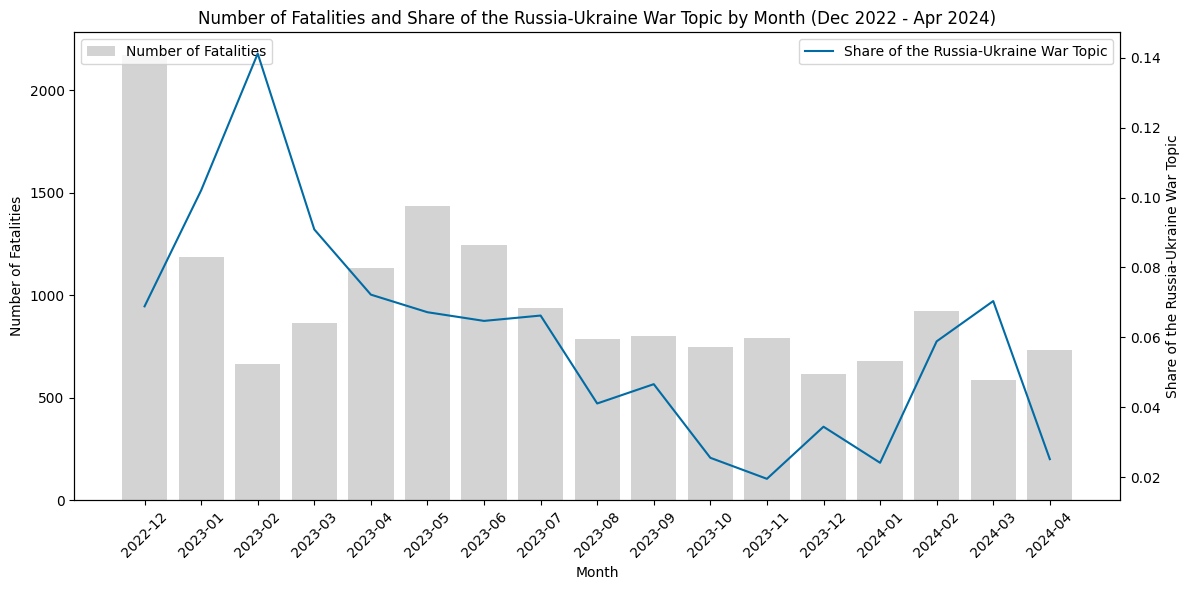

In [21]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'],  label='Share of the Russia-Ukraine War Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

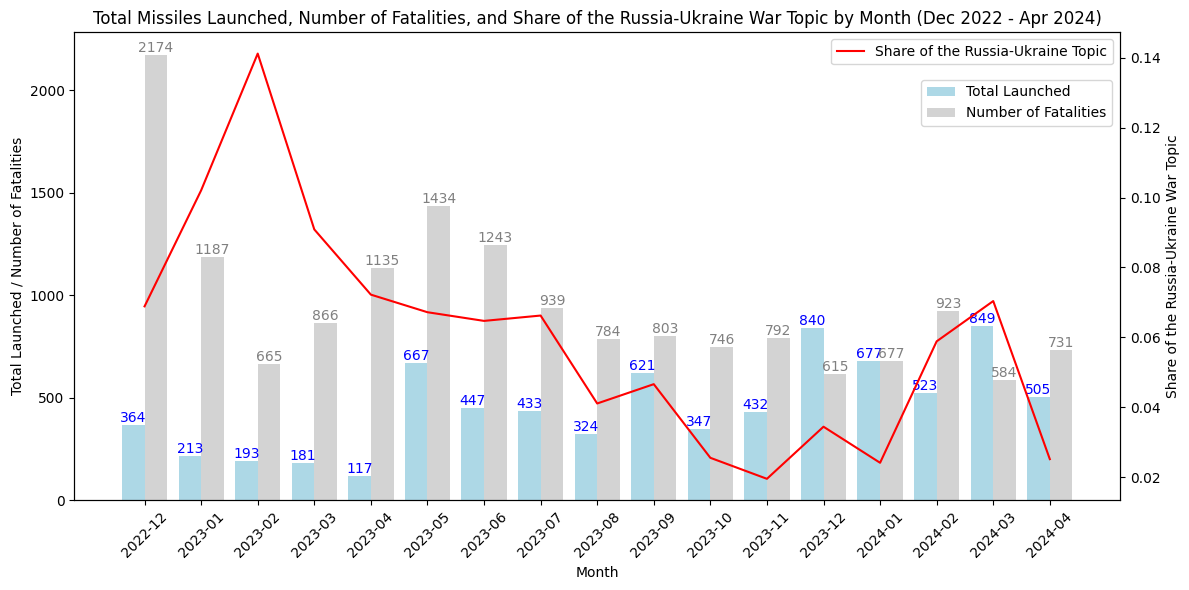

In [45]:
# Plotting missiles launched and fatalities together with share of war coverage

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.8))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


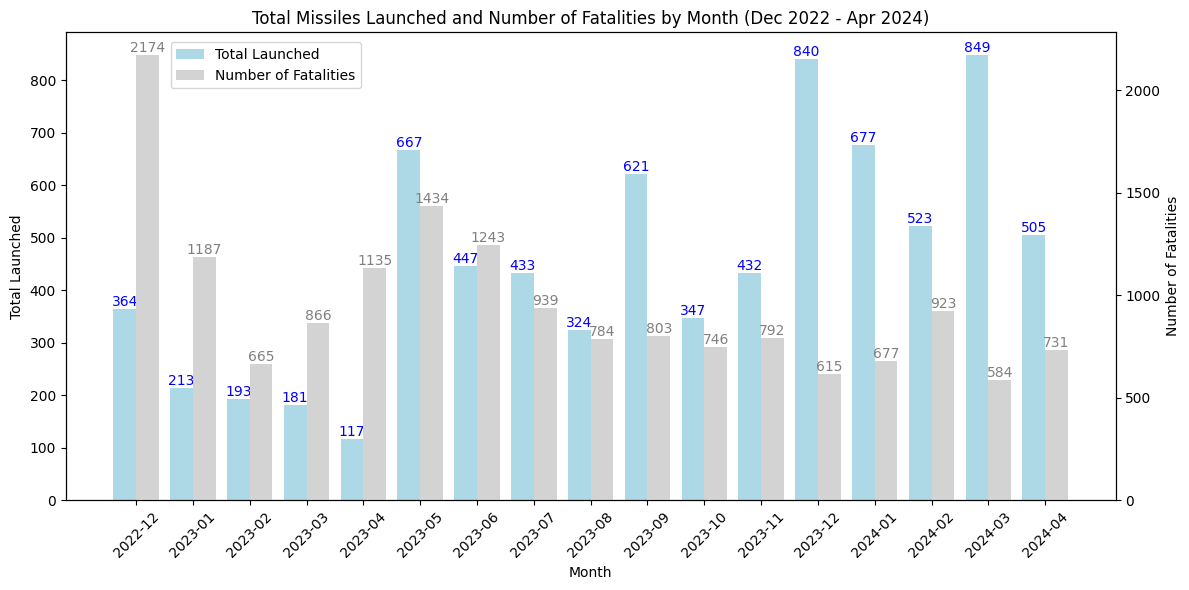

In [68]:
# Plotting fatalities and total launched together on different scales
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Add labels and title for ax1
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create a second y-axis for the Number of Fatalities
ax2 = ax1.twinx()
bars2 = ax2.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels for ax2
ax2.set_ylabel('Number of Fatalities')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.1, 0.88))
#ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Number of Fatalities by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


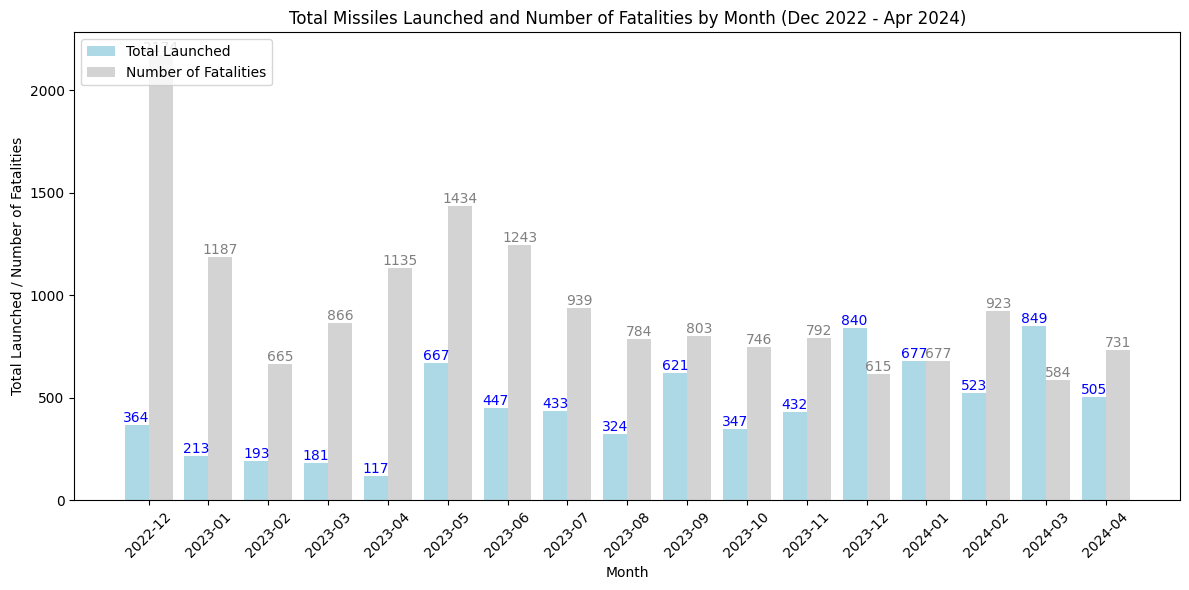

In [69]:
# Plotting fatalities and misslies launched on same scale

# Assuming df_aggregated is already defined DataFrame

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left')

plt.title('Total Missiles Launched and Number of Fatalities by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

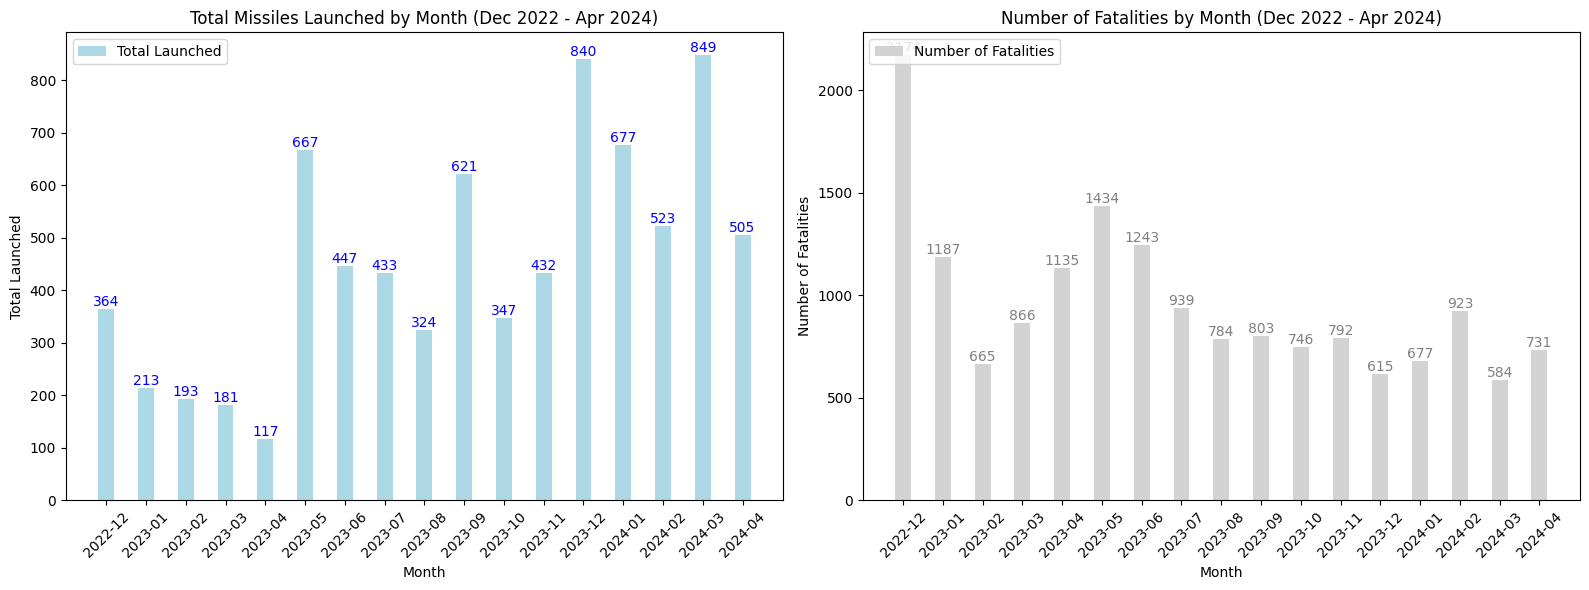

In [74]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)

# Plot the first bar chart (Total Launched) on ax1
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.set_title('Total Missiles Launched by Month (Dec 2022 - Apr 2024)')
ax1.set_xticks(r1)
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax1.legend(loc='upper left')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Plot the second bar chart (Number of Fatalities) on ax2
bars2 = ax2.bar(r1, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Fatalities')
ax2.set_title('Number of Fatalities by Month (Dec 2022 - Apr 2024)')
ax2.set_xticks(r1)
ax2.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax2.legend(loc='upper left')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

plt.tight_layout()
plt.show()

## Predictions on Entire Dataset

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import numpy as np
# from typing import List
# import os
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torchvision.io import read_image
# from torchvision import transforms, models
# from torch.utils.data import random_split
# from torchvision.transforms.functional import to_pil_image
# import torch.optim as optim
# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# from tqdm import tqdm
# import torch.nn.functional as F

In [21]:
# resnet50 = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

# # Freeze all the parameters
# for param in resnet50.parameters():
#     param.requires_grad = False

# # Replace the final fully connected layer
# num_ftrs = resnet50.fc.in_features
# # Define the custom head with two additional dense layers
# resnet50.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 512),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(512, 256),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(256, 1)
# )

# # Move the model to the GPU if available
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# resnet50 = resnet50.to(device)

In [22]:
# # Load the weights
# saved_weights_path = '/Users/viktoriia/Desktop/thesis/pytorch/model_weights/resnet50_TL-L4.pth'
# resnet50.load_state_dict(torch.load(saved_weights_path, map_location=device))

In [23]:
# class UnlabeledImageDataset(torch.utils.data.Dataset):
#     def __init__(self, img_dir, transform=None):
#         self.img_dir = img_dir
#         # self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
#         self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.lower().endswith(('jpeg', 'jpg', 'png', 'gif'))]
#         self.transform = transform

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         img_path = self.img_paths[idx]
#         image = read_image(img_path)
        
#         # Convert tensor to PIL image
#         image = to_pil_image(image)

#         if self.transform:
#             image = self.transform(image)

#         return image, img_path  # Return image and its path


# # Use same transformations as before
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

In [24]:
# # Create data loader
# img_dir = '/Users/viktoriia/Desktop/thesis/data/frames/la6'
# unlabeled_dataset = UnlabeledImageDataset(img_dir, transform=transform)
# unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

In [25]:
# def predict_unlabeled_images(model, dataloader):
#     model.eval()
#     all_probs = []
#     all_img_paths = []

#     with torch.no_grad():  # Disable gradient calculation for evaluation
#         for inputs, img_paths in tqdm(dataloader, desc="Predicting", unit="batch"):
#             inputs = inputs.to(device)
            
#             outputs = model(inputs)
#             probs = torch.sigmoid(outputs)
            
#             all_probs.extend(probs)
#             all_img_paths.extend(img_paths)
    
#     return all_img_paths, all_probs

In [26]:
# # Make predictions
# img_paths, predictions = predict_unlabeled_images(resnet50, unlabeled_dataloader)

In [27]:
# # Convert the list of tensors to a list of floats
# predictions = [pred.item() for pred in predictions]

# threshold = 0.6
# binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# # Create a DataFrame
# df = pd.DataFrame({
#     'filename': img_paths,
#     'predicted_class': binary_predictions
# })

# #TODO: convert to a dataframe
# df['date'] = df['filename'].apply(lambda x: x.split('_')[3])

In [28]:
# # Step 1: Convert the 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Step 2: Extract month and year
# df['year_month'] = df['date'].dt.to_period('M')

# # Group by year-month and calculate the share of class 1.0 observations
# share_class_1 = df.groupby('year_month')['predicted_class'].mean().reset_index()
# share_class_1

# # Rename the column for better clarity
# share_class_1 = share_class_1.rename(columns={'predicted_class': 'la6_share_class_1'})

# # Convert 'month_year' back to a datetime format for easier reading (optional)
# share_class_1['year_month'] = share_class_1['year_month'].dt.to_timestamp()

In [29]:
# df.to_csv('./la6_predictions.csv', index=False)
# share_class_1.to_csv('./la6_predictions_agg.csv', index=False)

In [22]:
# Load Predictions

a3_predictions = pd.read_csv('predictions/atres_predictions.csv')
a3_predictions['channel'] = 'a3'

la6_predictions = pd.read_csv('predictions/la6_predictions.csv')
la6_predictions['channel'] = 'la6'

t5_predictions = pd.read_csv('predictions/telecinco_predictions.csv')
t5_predictions['channel'] = 't5'

# Convert the 'date' column to datetime format
a3_predictions['date'] = pd.to_datetime(a3_predictions['date'])
la6_predictions['date'] = pd.to_datetime(la6_predictions['date'])
t5_predictions['date'] = pd.to_datetime(t5_predictions['date'])

# Extract month and year
a3_predictions['year_month'] = a3_predictions['date'].dt.to_period('M')
la6_predictions['year_month'] = la6_predictions['date'].dt.to_period('M')
t5_predictions['year_month'] = t5_predictions['date'].dt.to_period('M')

combined_predictions = pd.concat([a3_predictions, la6_predictions, t5_predictions])

In [23]:
# Group by year-month and calculate the share of class 1.0 observations
a3_share_class_1 = a3_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
la6_share_class_1 = la6_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
t5_share_class_1 = t5_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
combined_share_class_1 = combined_predictions.groupby('year_month')['predicted_class'].mean().reset_index()

# Rename the column for better clarity
a3_share_class_1 = a3_share_class_1.rename(columns={'predicted_class': 'a3_share_class_1'})
la6_share_class_1 = la6_share_class_1.rename(columns={'predicted_class': 'la6_share_class_1'})
t5_share_class_1 = t5_share_class_1.rename(columns={'predicted_class': 't5_share_class_1'})
combined_share_class_1 = combined_share_class_1.rename(columns={'predicted_class': 'total_share_class_1'})

# Convert 'month_year' back to a datetime format for easier reading (optional)
a3_share_class_1['year_month'] = a3_share_class_1['year_month'].dt.to_timestamp()
la6_share_class_1['year_month'] = la6_share_class_1['year_month'].dt.to_timestamp()
t5_share_class_1['year_month'] = t5_share_class_1['year_month'].dt.to_timestamp()
combined_share_class_1['year_month'] = combined_share_class_1['year_month'].dt.to_timestamp()

In [24]:
# Merge data
final_df = pd.merge(df_aggregated, a3_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, la6_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, t5_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, combined_share_class_1, on='year_month', how='left')
final_df.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174,0.172467,0.212945,0.198678,0.196723
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187,0.255780,0.321944,0.318334,0.306667
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665,0.220494,0.215436,0.204096,0.211006
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866,0.265193,0.256988,0.292427,0.272245
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135,0.221421,0.236270,0.283354,0.250800


In [33]:
# final_df.to_csv('aggregated_data.csv')

## Trends Analysis

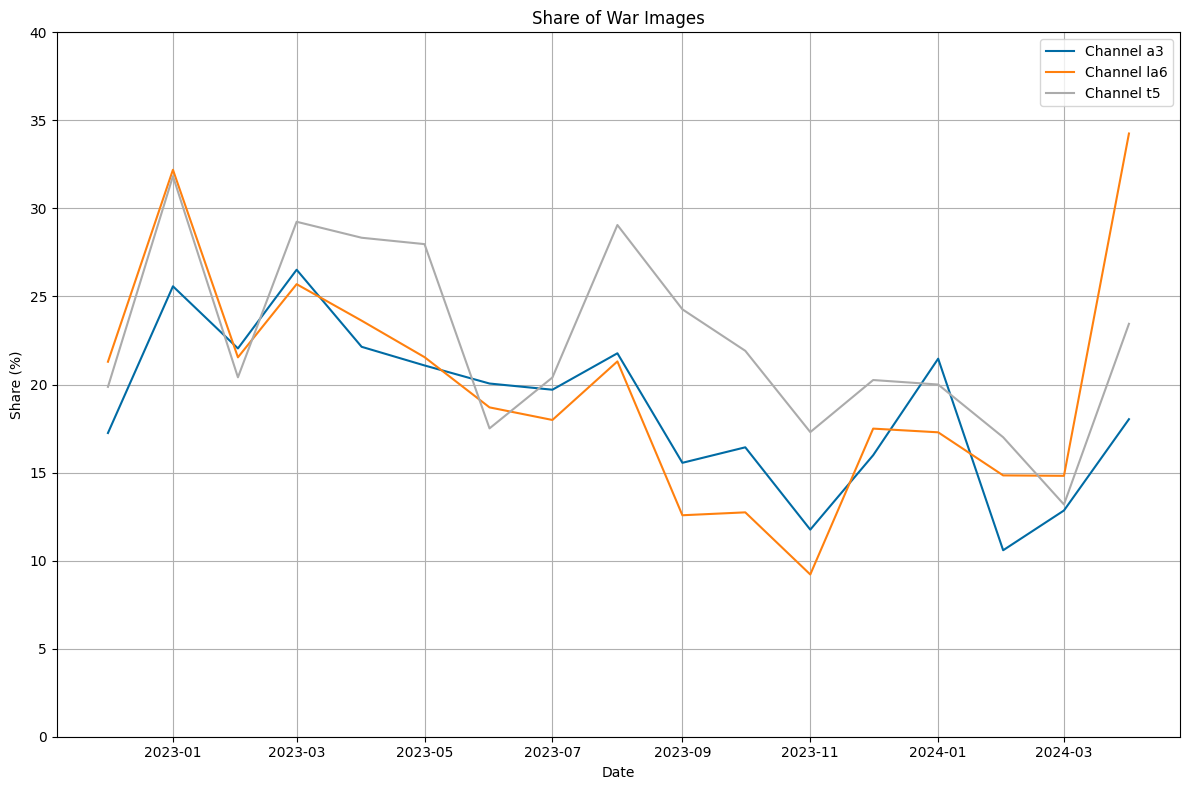

In [25]:
# Share of war images by month and channel

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(final_df['year_month'], final_df['a3_share_class_1'] * 100, label=f'Channel a3')
plt.plot(final_df['year_month'], final_df['la6_share_class_1'] * 100, label=f'Channel la6')
plt.plot(final_df['year_month'], final_df['t5_share_class_1'] * 100, label=f'Channel t5')

plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

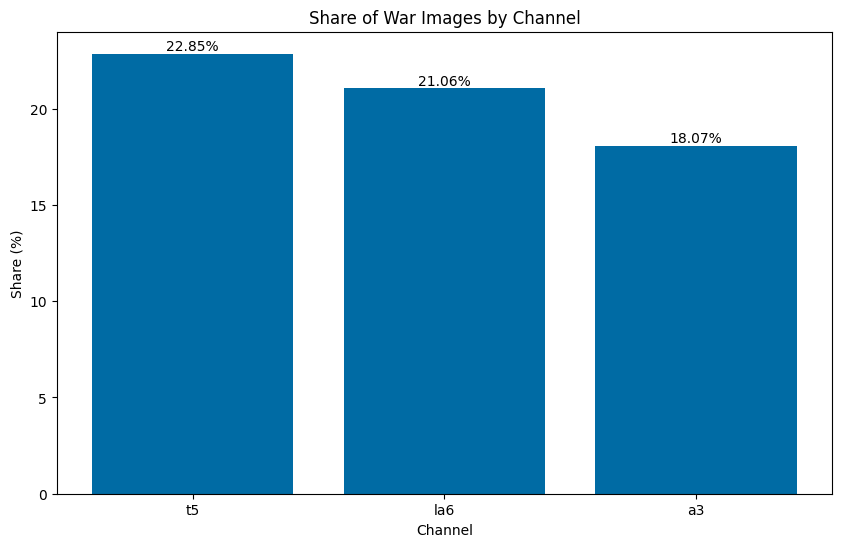

In [26]:
# Share of war images by channel
combined_share_class_1_by_channel = combined_predictions.groupby('channel')['predicted_class'].mean().reset_index()

# Sort the DataFrame by 'predicted_class' in descending order
combined_share_class_1_by_channel = combined_share_class_1_by_channel.sort_values(by='predicted_class', ascending=False)

# Convert 'share_with_ukraine' to percentages
combined_share_class_1_by_channel['predicted_class'] = combined_share_class_1_by_channel['predicted_class'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_share_class_1_by_channel['channel'], combined_share_class_1_by_channel['predicted_class'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of War Images by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

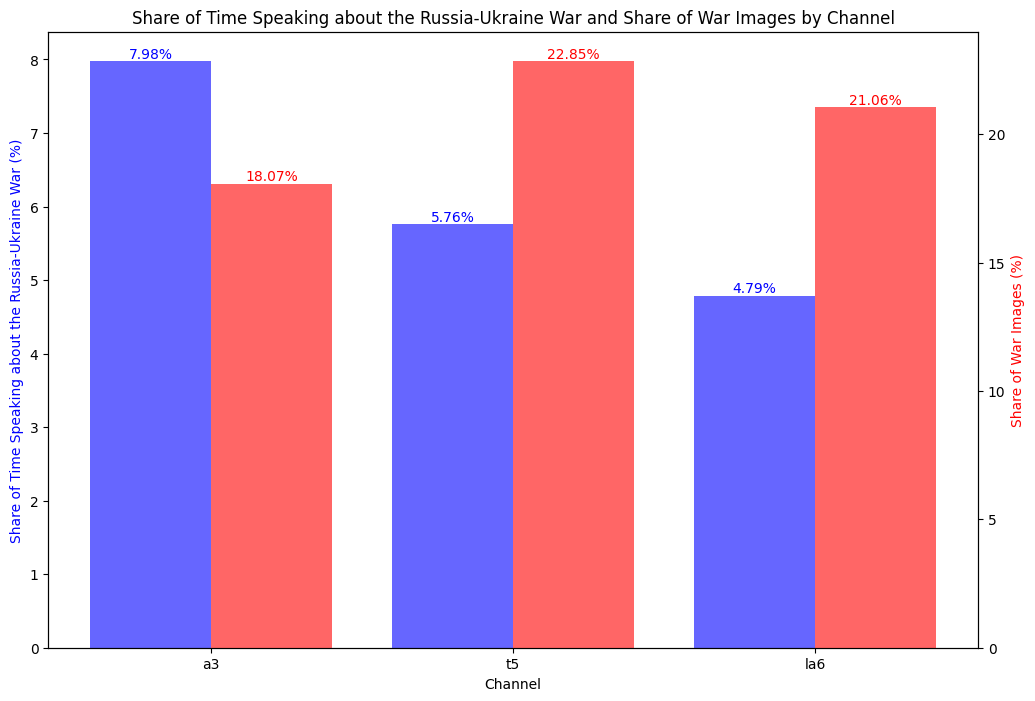

In [29]:
# Plot share of war images by channel with share of topic ukraine by channel

channels = channel_summary['channel']
combined_share_class_1_by_channel = combined_share_class_1_by_channel.set_index('channel').loc[channels].reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Number of bars and their width
n = len(channels)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart
bars1 = ax1.bar(r1, channel_summary['share_with_ukraine'], color='b', width=bar_width, alpha=0.6, label='Share of Time Speaking about the Russia-Ukraine War')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second bar chart
bars2 = ax2.bar(r2, combined_share_class_1_by_channel['predicted_class'], color='r', width=bar_width, alpha=0.6, label='Share of War Images')

# Add labels and title
ax1.set_xlabel('Channel')
ax1.set_ylabel('Share of Time Speaking about the Russia-Ukraine War (%)', color='b')
ax2.set_ylabel('Share of War Images (%)', color='r')
plt.title('Share of Time Speaking about the Russia-Ukraine War and Share of War Images by Channel')

# Set the position of the x ticks
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(channels)

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', color='b')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', color='r')

# Adding a legend
bars = [bars1, bars2]
labels = [bar[0].get_label() for bar in bars]

# Display the plot
plt.show()


In [36]:
final_df.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174,0.172467,0.212945,0.198678,0.196723
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187,0.255780,0.321944,0.318334,0.306667
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665,0.220494,0.215436,0.204096,0.211006
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866,0.265193,0.256988,0.292427,0.272245
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135,0.221421,0.236270,0.283354,0.250800


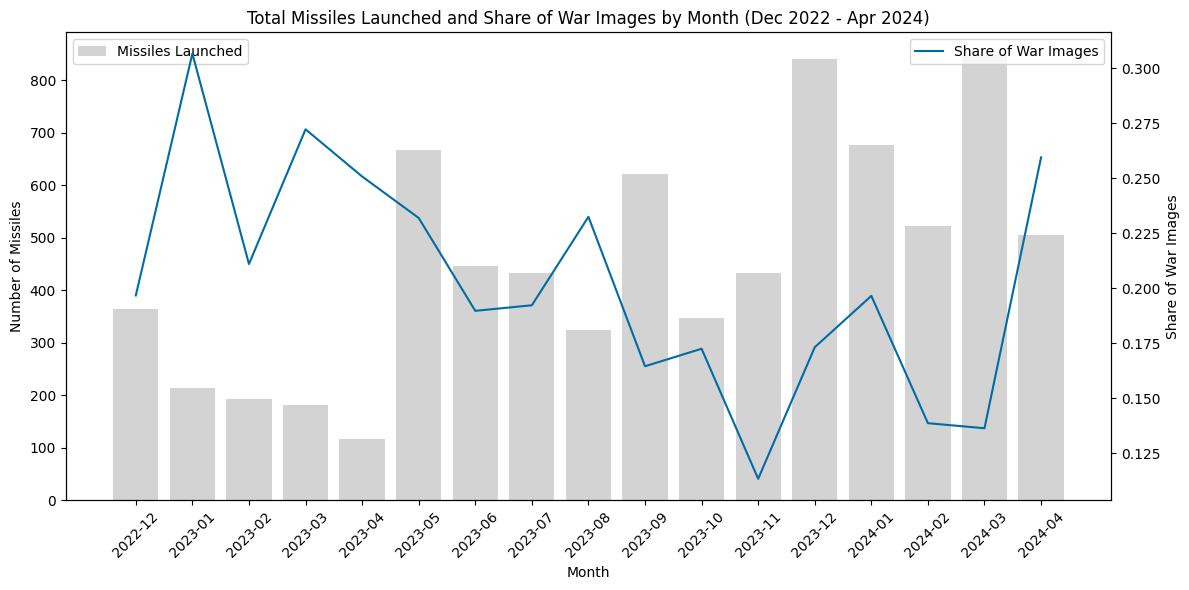

In [37]:
# Num of missiles vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['launched'], color='lightgrey', label='Missiles Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Missiles')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

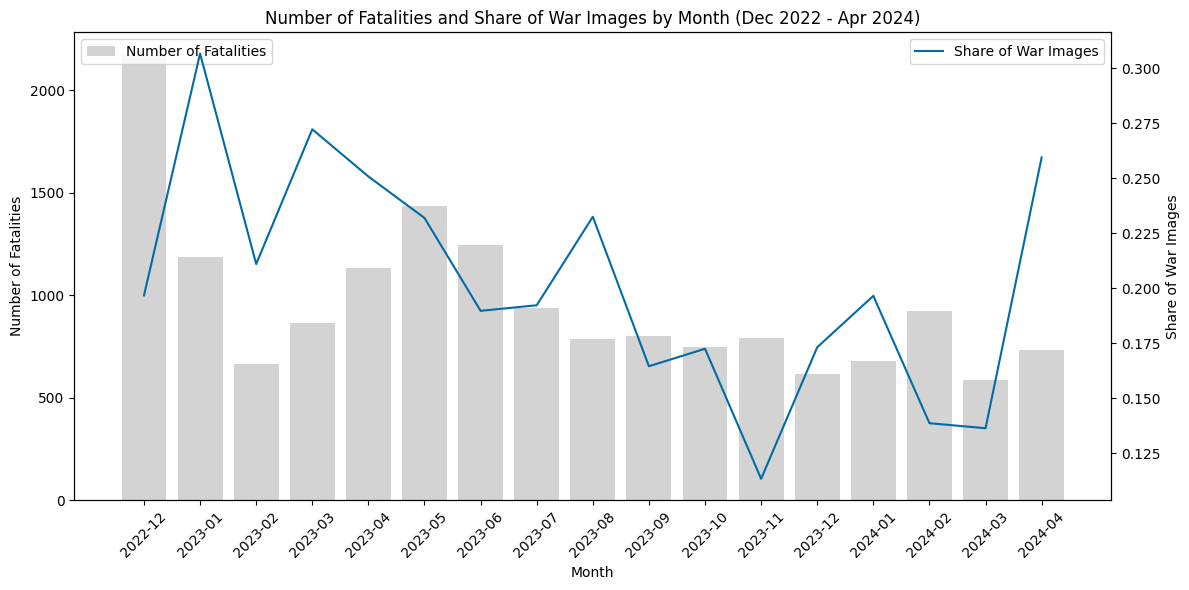

In [38]:
# Num of fatalities vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

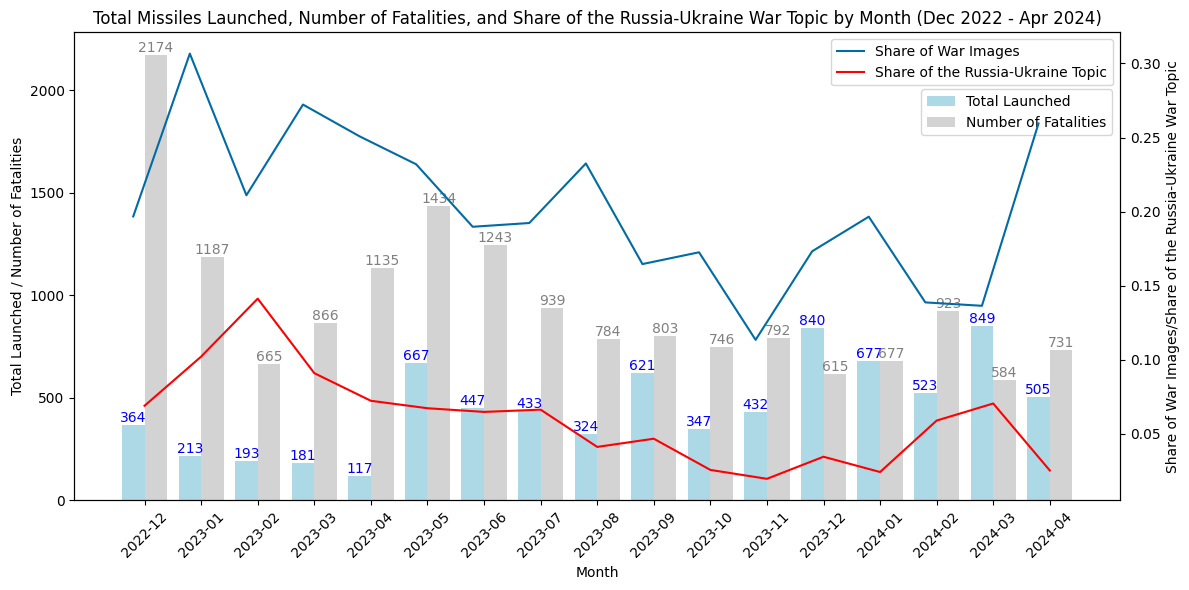

In [49]:
# Plotting number of missles and fatalities together with share of war images and share of coverage of the war

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of War Images/Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.78))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


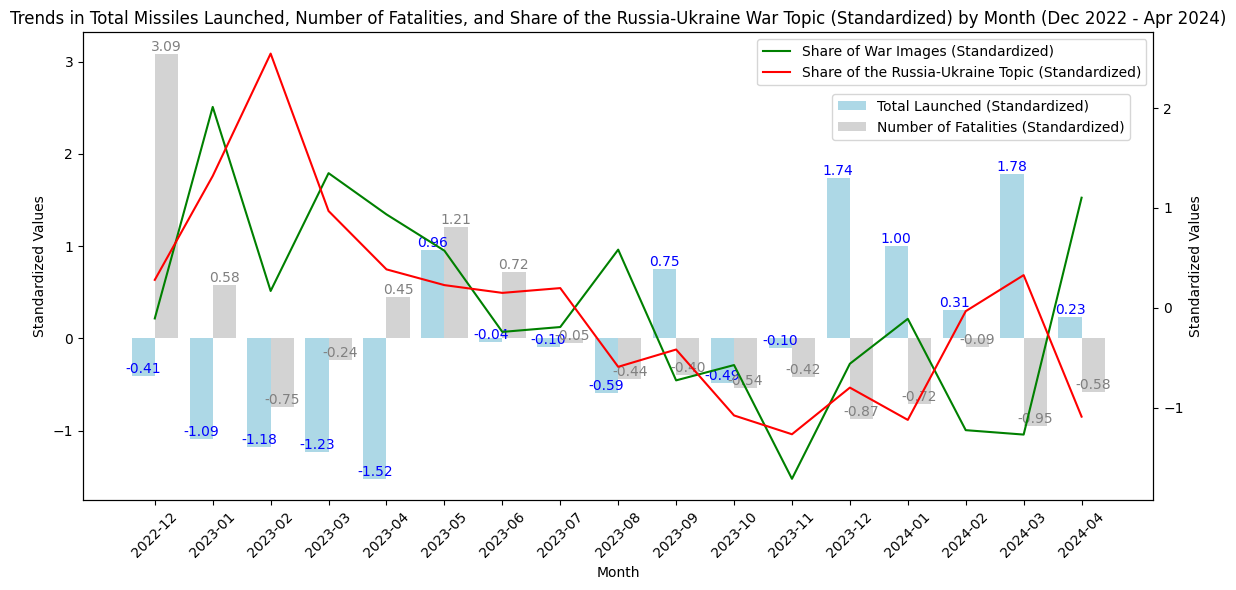

In [60]:
# Plotting standardised values of the above chart to make the trends easier to see

# Standardize the values
df_aggregated['launched_z'] = (df_aggregated['launched'] - df_aggregated['launched'].mean()) / df_aggregated['launched'].std()
df_aggregated['fatalities_z'] = (df_aggregated['fatalities'] - df_aggregated['fatalities'].mean()) / df_aggregated['fatalities'].std()
df_aggregated['share_with_ukraine_z'] = (df_aggregated['share_with_ukraine'] - df_aggregated['share_with_ukraine'].mean()) / df_aggregated['share_with_ukraine'].std()
final_df['total_share_class_1_z'] = (final_df['total_share_class_1'] - final_df['total_share_class_1'].mean()) / final_df['total_share_class_1'].std()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched standardized)
bars1 = ax1.bar(r1, df_aggregated['launched_z'], color='lightblue', width=bar_width, label='Total Launched (Standardized)')

# Plot the second bar chart (Number of Fatalities standardized)
bars2 = ax1.bar(r2, df_aggregated['fatalities_z'], color='lightgrey', width=bar_width, label='Number of Fatalities (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, final_df['total_share_class_1_z'], color='g', label='Share of War Images (Standardized)')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine_z'], color='r', label='Share of the Russia-Ukraine Topic (Standardized)')
ax2.set_ylabel('Standardized Values')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.7, 0.77))
ax2.legend(loc='upper right')

plt.title('Trends in Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic (Standardized) by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

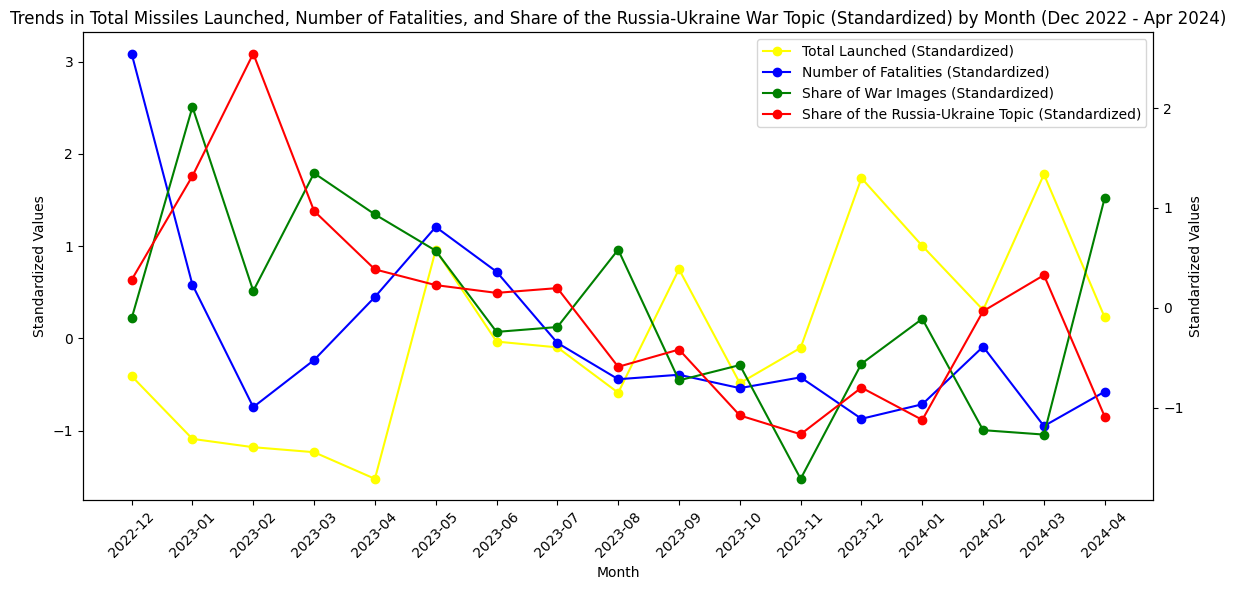

In [54]:
# Same standarised plot as above but with all lines rather than bars for real data

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of data points
n = len(df_aggregated)
months = df_aggregated['year_month'].dt.strftime('%Y-%m')

# Plot the first line chart (Total Launched standardized)
ax1.plot(months, df_aggregated['launched_z'], color='yellow', marker='o', label='Total Launched (Standardized)')

# Plot the second line chart (Number of Fatalities standardized)
ax1.plot(months, df_aggregated['fatalities_z'], color='blue', marker='o', label='Number of Fatalities (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')
ax1.set_xticks(np.arange(n))
ax1.set_xticklabels(months, rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(months, final_df['total_share_class_1_z'], color='g', marker='o', label='Share of War Images (Standardized)')
ax2.plot(months, df_aggregated['share_with_ukraine_z'], color='r', marker='o', label='Share of the Russia-Ukraine Topic (Standardized)')
ax2.set_ylabel('Standardized Values')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Trends in Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic (Standardized) by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

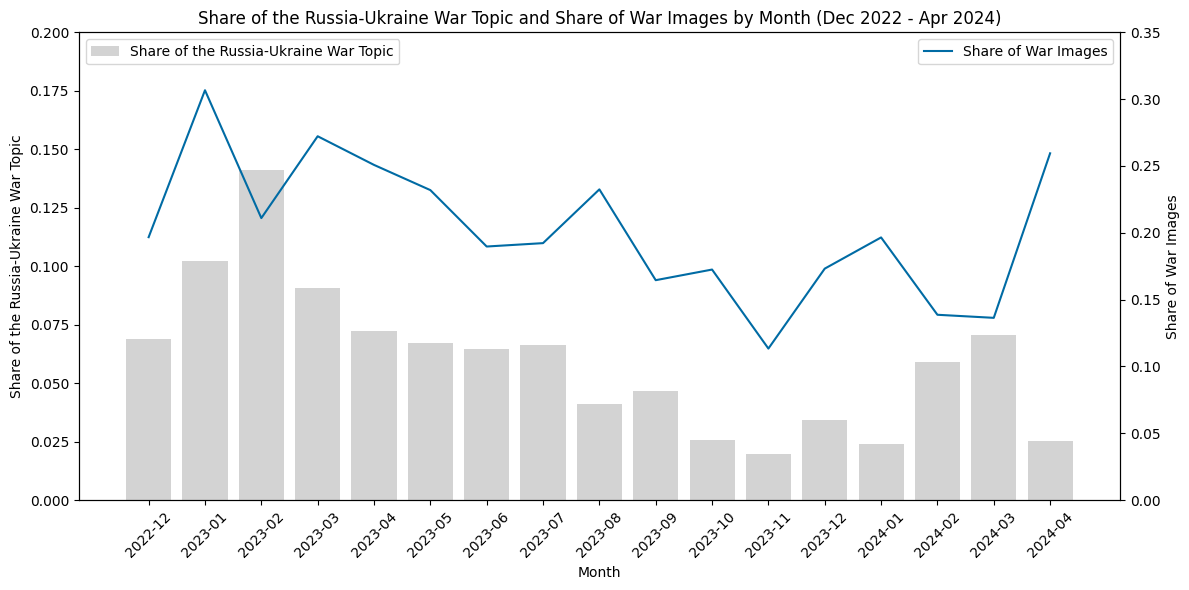

In [39]:
# Share of the Russia-Ukraine war topic vs share_class_1 (total)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

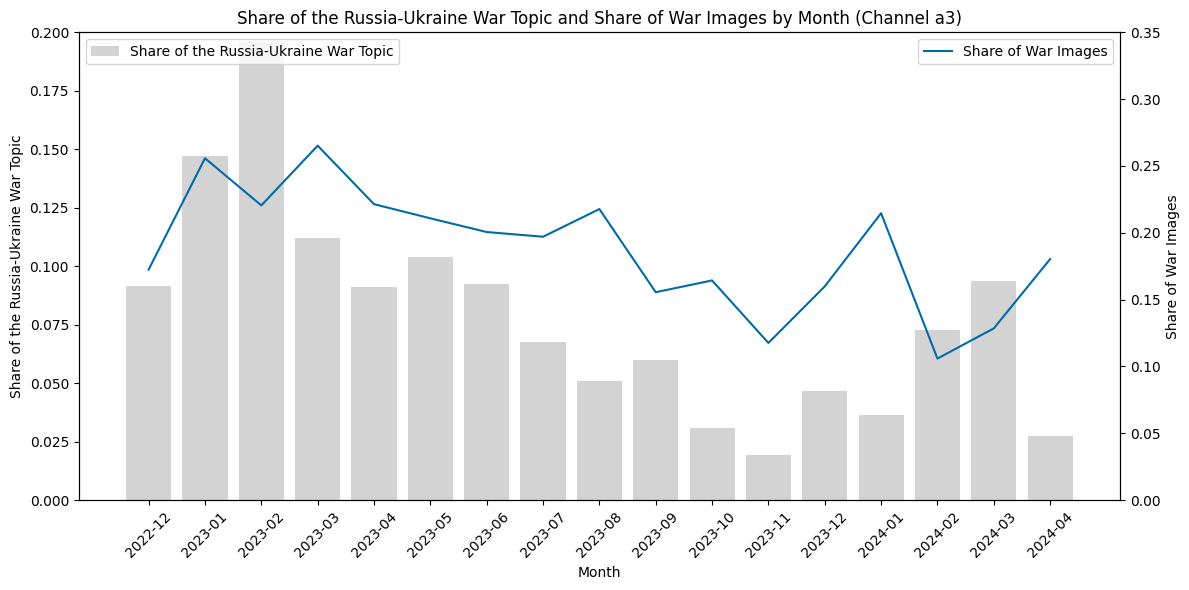

In [40]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (a3)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['a3_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['a3_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel a3)')
plt.tight_layout()
plt.show()

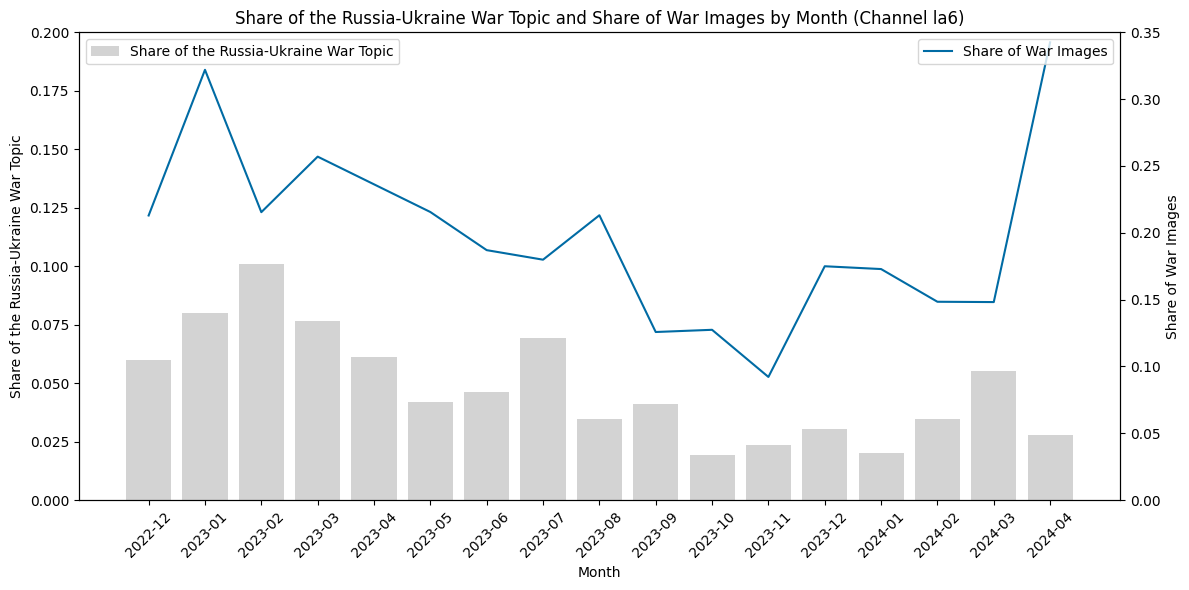

In [41]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (la6)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['la6_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['la6_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel la6)')
plt.tight_layout()
plt.show()

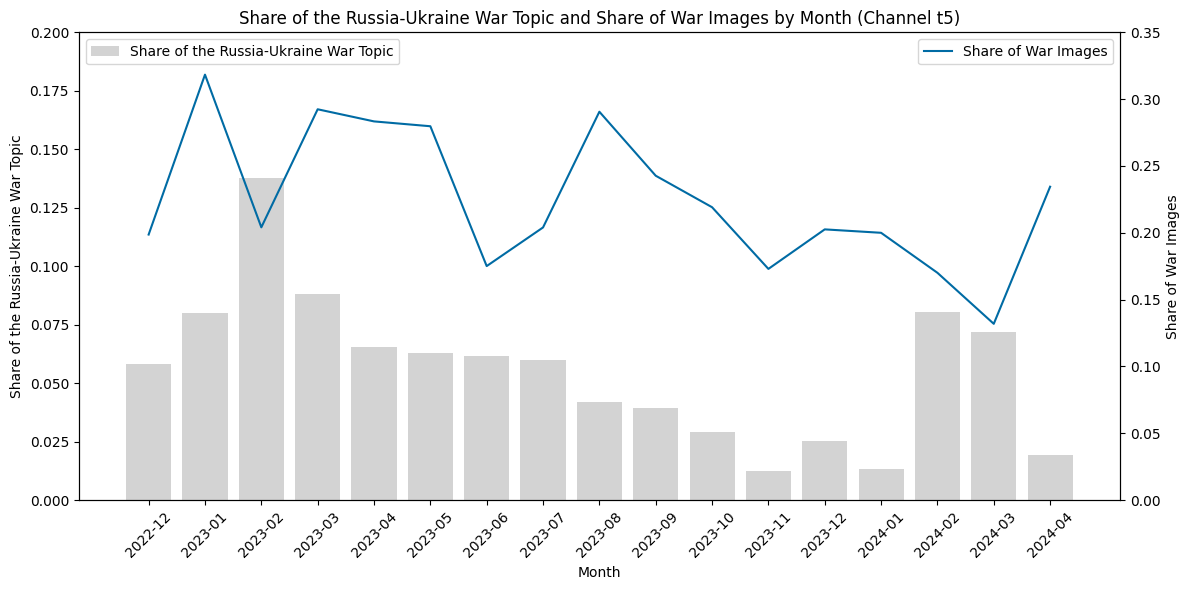

In [42]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (t5)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['t5_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['t5_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel t5)')
plt.tight_layout()
plt.show()